In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils as vutils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
learning_rate = 0.0002
size_of_batch = 64
num_epochs = 10
critic_iter = 5
noise_dim = 100
output_folder="./WGANOutput"

In [3]:
data_set = datasets.CIFAR10(root="./data", download=True, transform=transforms.Compose([
    transforms.Resize(64),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
data_loader = torch.utils.data.DataLoader(data_set, batch_size = 128, shuffle=True, num_workers=2)

Files already downloaded and verified


In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main=nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0),
        )
    def forward(self, passedInput):
        return self.main(passedInput).mean(0).view(1)


class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main=nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, passedInput):
        return self.main(passedInput)

In [6]:
discriminator = Discriminator()

generator = Generator()

discriminator.apply(weights_init)
generator.apply(weights_init)
discriminator
generator

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [7]:

dis_optim = optim.RMSprop(discriminator.parameters(),lr=learning_rate)
gen_optim = optim.RMSprop(generator.parameters(),lr=learning_rate)
criterion = nn.BCELoss()

real_value = 1
fake_value = 0
input_tensor = torch.FloatTensor(size_of_batch, 3, 64, 64)
noise = torch.FloatTensor(size_of_batch, noise_dim, 1, 1)
norm_noise = torch.FloatTensor(size_of_batch, noise_dim, 1, 1).normal_(0, 1)
norm_noise = Variable(norm_noise)
ones_tensor = torch.FloatTensor([1])
nOnesTensor=ones_tensor * (-1)
criterion.cuda()


disc_loss_list = []
gen_loss_list = []
count_list = []
count = 0 

In [8]:
for epoch in range(num_epochs):
    epochData = iter(data_loader)
    data_counter = 0
    
    
    while data_counter < len(data_loader):
        for param in discriminator.parameters():
            param.requires_grad=True
        
        
        critic_counter = 0
        while data_counter < len(data_loader) and critic_counter < critic_iter:
            data = next(epochData)
            critic_counter += 1
            for param in discriminator.parameters():
                param.data.clamp_(-1e-2, 1e-2)
            data_counter += 1
            
            
            dis_optim.zero_grad()
            real_data, _ = data
            size_of_batch = real_data.size(0)
            real_data = real_data
            input_tensor.resize_as_(real_data).copy_(real_data)
            input_var = Variable(input_tensor)
            dis_real_error = discriminator(input_var)
            dis_real_error.backward(ones_tensor)

            
            noise.resize_(size_of_batch, noise_dim, 1,1).normal_(0,1)
            noise_var = Variable(noise)
            fake_data = generator(noise_var)
            dis_fake_error = discriminator(fake_data.detach())
            dis_fake_error.backward(nOnesTensor)
            dis_optim.step()
            final_dis_error = -dis_fake_error + dis_real_error
            
        
        for param in discriminator.parameters():
            param.requires_grad = False
        gen_optim.zero_grad()
        gen_error = discriminator(fake_data)
        gen_error.backward(ones_tensor)
        gen_optim.step()
        
        
        print('[%d/%d][%d/%d] DLoss: %.4f GLoss: %.4f' % 
             (epoch, num_epochs, data_counter, len(data_loader), final_dis_error.data[0], gen_error.data[0]))

        count += 1
        count_list.append(count)
        gen_loss_list.append(gen_error.data.cpu().numpy()[0])
        disc_loss_list.append(final_dis_error.data.cpu().numpy()[0])
    
    
    fake_data = generator(norm_noise)
    fake_data.data = fake_data.data.mul(0.5).add(0.5)
    vutils.save_image(fake_data.data, '%s/fake_samples_epoch_%03d.png' % 
                      (output_folder, epoch), normalize=True)

[0/10][5/391] DLoss: -0.4159 GLoss: 0.4216
[0/10][10/391] DLoss: -0.9142 GLoss: 0.5668
[0/10][15/391] DLoss: -1.0706 GLoss: 0.6330
[0/10][20/391] DLoss: -1.1683 GLoss: 0.6231
[0/10][25/391] DLoss: -1.0999 GLoss: 0.5969
[0/10][30/391] DLoss: -0.9979 GLoss: 0.6098
[0/10][35/391] DLoss: -0.6748 GLoss: 0.5876
[0/10][40/391] DLoss: -1.1324 GLoss: 0.5955
[0/10][45/391] DLoss: -0.6980 GLoss: 0.2036
[0/10][50/391] DLoss: -0.6226 GLoss: 0.4187
[0/10][55/391] DLoss: -0.9733 GLoss: 0.6159
[0/10][60/391] DLoss: -1.2758 GLoss: 0.7043
[0/10][65/391] DLoss: -1.3837 GLoss: 0.7342
[0/10][70/391] DLoss: -1.4011 GLoss: 0.7401
[0/10][75/391] DLoss: -1.3862 GLoss: 0.7327
[0/10][80/391] DLoss: -1.4334 GLoss: 0.7489
[0/10][85/391] DLoss: -1.4536 GLoss: 0.7525
[0/10][90/391] DLoss: -1.4573 GLoss: 0.7535
[0/10][95/391] DLoss: -1.4571 GLoss: 0.7522
[0/10][100/391] DLoss: -1.4752 GLoss: 0.7565
[0/10][105/391] DLoss: -1.4855 GLoss: 0.7620
[0/10][110/391] DLoss: -1.4877 GLoss: 0.7574
[0/10][115/391] DLoss: -1.4743

[2/10][135/391] DLoss: -1.1901 GLoss: 0.5898
[2/10][140/391] DLoss: -1.0636 GLoss: 0.6461
[2/10][145/391] DLoss: -1.1847 GLoss: 0.6148
[2/10][150/391] DLoss: -1.0990 GLoss: 0.6658
[2/10][155/391] DLoss: -1.1926 GLoss: 0.6191
[2/10][160/391] DLoss: -0.9159 GLoss: 0.6557
[2/10][165/391] DLoss: -1.1350 GLoss: 0.5869
[2/10][170/391] DLoss: -0.9543 GLoss: 0.6601
[2/10][175/391] DLoss: -1.1965 GLoss: 0.6067
[2/10][180/391] DLoss: -1.1529 GLoss: 0.6261
[2/10][185/391] DLoss: -1.1679 GLoss: 0.5936
[2/10][190/391] DLoss: -1.1153 GLoss: 0.6423
[2/10][195/391] DLoss: -1.1684 GLoss: 0.5586
[2/10][200/391] DLoss: -1.0803 GLoss: 0.6614
[2/10][205/391] DLoss: -1.1202 GLoss: 0.5516
[2/10][210/391] DLoss: -1.1377 GLoss: 0.6563
[2/10][215/391] DLoss: -1.1407 GLoss: 0.5646
[2/10][220/391] DLoss: -0.9404 GLoss: 0.6400
[2/10][225/391] DLoss: -1.1719 GLoss: 0.5940
[2/10][230/391] DLoss: -1.1196 GLoss: 0.6311
[2/10][235/391] DLoss: -1.1669 GLoss: 0.5973
[2/10][240/391] DLoss: -1.1457 GLoss: 0.6021
[2/10][245

[4/10][260/391] DLoss: -0.6805 GLoss: 0.2086
[4/10][265/391] DLoss: -0.9346 GLoss: 0.4395
[4/10][270/391] DLoss: -0.9627 GLoss: 0.6152
[4/10][275/391] DLoss: -1.0880 GLoss: 0.5625
[4/10][280/391] DLoss: -0.8538 GLoss: 0.6505
[4/10][285/391] DLoss: -0.9734 GLoss: 0.4124
[4/10][290/391] DLoss: -0.9670 GLoss: 0.6030
[4/10][295/391] DLoss: -1.0089 GLoss: 0.5123
[4/10][300/391] DLoss: -0.9332 GLoss: 0.6450
[4/10][305/391] DLoss: -1.1118 GLoss: 0.5288
[4/10][310/391] DLoss: -1.0175 GLoss: 0.6318
[4/10][315/391] DLoss: -1.0491 GLoss: 0.4666
[4/10][320/391] DLoss: -0.9204 GLoss: 0.6064
[4/10][325/391] DLoss: -1.0186 GLoss: 0.5356
[4/10][330/391] DLoss: -0.9353 GLoss: 0.6201
[4/10][335/391] DLoss: -0.8846 GLoss: 0.3187
[4/10][340/391] DLoss: -1.0092 GLoss: 0.6271
[4/10][345/391] DLoss: -1.0783 GLoss: 0.5171
[4/10][350/391] DLoss: -0.9394 GLoss: 0.6278
[4/10][355/391] DLoss: -1.0502 GLoss: 0.4943
[4/10][360/391] DLoss: -0.7498 GLoss: 0.6251
[4/10][365/391] DLoss: -0.9609 GLoss: 0.4659
[4/10][370

[6/10][385/391] DLoss: -0.7356 GLoss: 0.2198
[6/10][390/391] DLoss: -0.9366 GLoss: 0.4763
[6/10][391/391] DLoss: -0.4255 GLoss: 0.5707
[7/10][5/391] DLoss: -0.9325 GLoss: 0.4560
[7/10][10/391] DLoss: -0.8387 GLoss: 0.6362
[7/10][15/391] DLoss: -1.0659 GLoss: 0.5065
[7/10][20/391] DLoss: -0.8774 GLoss: 0.6230
[7/10][25/391] DLoss: -0.9299 GLoss: 0.3932
[7/10][30/391] DLoss: -0.9479 GLoss: 0.5887
[7/10][35/391] DLoss: -1.0322 GLoss: 0.5387
[7/10][40/391] DLoss: -0.9266 GLoss: 0.6390
[7/10][45/391] DLoss: -0.9311 GLoss: 0.3428
[7/10][50/391] DLoss: -1.0667 GLoss: 0.6063
[7/10][55/391] DLoss: -1.0476 GLoss: 0.5384
[7/10][60/391] DLoss: -0.9016 GLoss: 0.6275
[7/10][65/391] DLoss: -0.8554 GLoss: 0.3464
[7/10][70/391] DLoss: -1.1305 GLoss: 0.5914
[7/10][75/391] DLoss: -1.1184 GLoss: 0.5869
[7/10][80/391] DLoss: -0.6528 GLoss: 0.5919
[7/10][85/391] DLoss: -0.8129 GLoss: 0.2052
[7/10][90/391] DLoss: -0.8516 GLoss: 0.4866
[7/10][95/391] DLoss: -0.9430 GLoss: 0.6084
[7/10][100/391] DLoss: -1.0760

[9/10][120/391] DLoss: -0.7321 GLoss: 0.1569
[9/10][125/391] DLoss: -1.0272 GLoss: 0.5019
[9/10][130/391] DLoss: -1.0586 GLoss: 0.6322
[9/10][135/391] DLoss: -1.1124 GLoss: 0.5293
[9/10][140/391] DLoss: -0.7979 GLoss: 0.6058
[9/10][145/391] DLoss: -0.9493 GLoss: 0.3449
[9/10][150/391] DLoss: -1.1998 GLoss: 0.6198
[9/10][155/391] DLoss: -1.1922 GLoss: 0.5725
[9/10][160/391] DLoss: -0.7599 GLoss: 0.6481
[9/10][165/391] DLoss: -0.6369 GLoss: 0.1848
[9/10][170/391] DLoss: -1.1710 GLoss: 0.5618
[9/10][175/391] DLoss: -1.2093 GLoss: 0.6049
[9/10][180/391] DLoss: -1.1970 GLoss: 0.6163
[9/10][185/391] DLoss: -0.7885 GLoss: 0.6451
[9/10][190/391] DLoss: -0.9505 GLoss: 0.2893
[9/10][195/391] DLoss: -1.2429 GLoss: 0.6030
[9/10][200/391] DLoss: -1.2687 GLoss: 0.6385
[9/10][205/391] DLoss: -1.2692 GLoss: 0.6459
[9/10][210/391] DLoss: -1.2530 GLoss: 0.6167
[9/10][215/391] DLoss: -1.1639 GLoss: 0.6372
[9/10][220/391] DLoss: -1.1532 GLoss: 0.5048
[9/10][225/391] DLoss: -0.3947 GLoss: 0.5976
[9/10][230

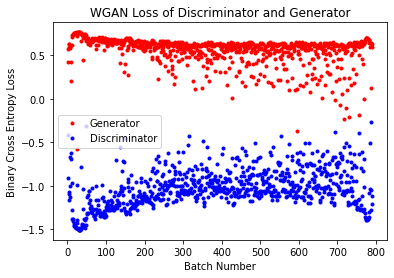

In [9]:
plt.plot(count_list, gen_loss_list, 'r.', label='Generator')
plt.plot(count_list, disc_loss_list, 'b.', label='Discriminator')
plt.title("WGAN Loss of Discriminator and Generator")
plt.xlabel("Batch Number")
plt.ylabel("Binary Cross Entropy Loss")
plt.legend(loc = "best")
plt.show()